# Third CatLearn tutorial.

This tutorial is intended to give further intuition for the Gaussian process and compare it to a linear model.

Like in tutorial 1, we set up a known underlying function, generate training and test data and calculate predictions and errors. We will compare the results of linear ridge regression, Gaussian linear kernel regression and finally a Gaussian process with the usual squared exponential kernel.

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess, RidgeRegression
from catlearn.regression.cost_function import get_error

In [2]:
# A known underlying function in two dimensions
def afunc(x):
    """2D linear function (plane)."""
    return 3. * x[:, 0] - 1. * x[:, 1] + 500.

We now set up a dataset with 2 training features and one target feature.

In [3]:
# Setting up data.
# A number of training points in x.
train_points = 17
# Magnitude of the noise.
noise_magnitude = 0.5

# Randomly generate the training datapoints x.
train_d1 = 2 * (np.random.random_sample(train_points) - 0.5)
train_d2 = 2 * (np.random.random_sample(train_points) - 0.5)
train_x1, train_x2 = np.meshgrid(train_d1, train_d2)
train = np.hstack([np.vstack(train_d1), np.vstack(train_d2)])

# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
for i in range(train_points):
    target[i] += noise_magnitude * np.random.normal()

# Generate test datapoints x.
test_points = 16
test1d = np.vstack(np.linspace(-1.3, 1.3, test_points))
test_x1, test_x2 = np.meshgrid(test1d, test1d)
test = np.hstack([np.vstack(test_x1.ravel()), np.vstack(test_x2.ravel())])

print(np.shape(train))
print(np.shape(test))
print(np.shape(target))

# Standardize the training and test data on the same scale.
std = standardize(train_matrix=train,
                  test_matrix=test)

# Standardize the training targets.
train_targets = target_standardize(target)
# Note that predictions will now be made on the standardized scale.

(17, 2)
(256, 2)
(17,)


## Model example 1 - Ridge regression.

Ridge regression prediction: 0.1875124250078491


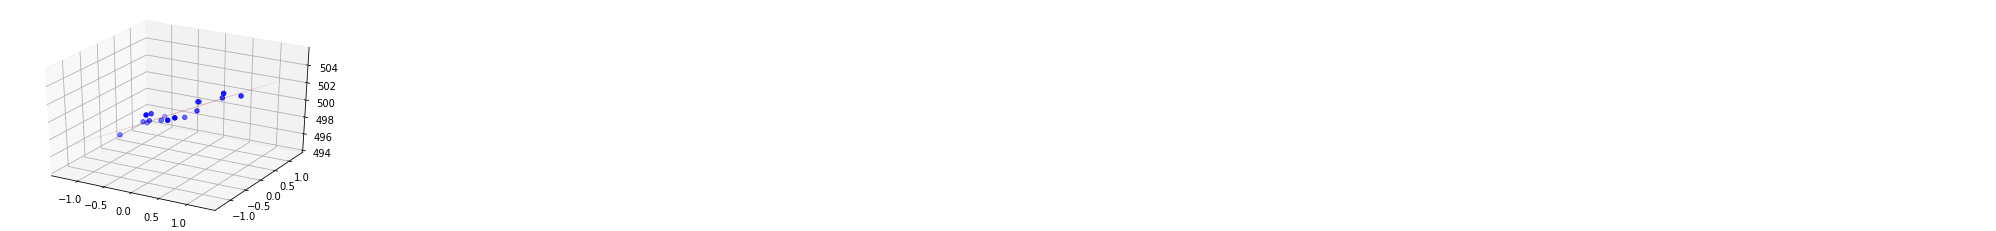

In [4]:
# Test ridge regression predictions.
rr = RidgeRegression()
reg = rr.find_optimal_regularization(X=std['train'],
                                     Y=train_targets['target'])
coef = rr.RR(X=std['train'], Y=train_targets['target'], omega2=reg)[0]
# Test the model.
sumd = 0.
rr_predictions = []
for tf, tt in zip(std['test'], afunc(test)):
    p = ((np.dot(coef, tf)) * train_targets['std']) + train_targets['mean']
    rr_predictions.append(p)
    sumd += (p - tt) ** 2
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   np.array(rr_predictions).reshape(np.shape(test_x1)),
                   alpha=0.3, color='r')
print('Ridge regression prediction:', (sumd / len(test)) ** 0.5)

This is a linear model with L2 regularization also known as ridge regression. The predicted function is therefore a plane in 3 dimensions.

These examples run on our 3 feature data set (including the target), so we need to plot the resulting models and training data in 3D plots. To get a matplotlib interactive window, where you can rotate the data, you can run the `linear_models.py` file in this directory.

You can also step through the notebook here and view a 2D projection of the results.

## Model example 2 - Gausian linear kernel regression.

Gaussian linear regression prediction: 0.1425735782826396


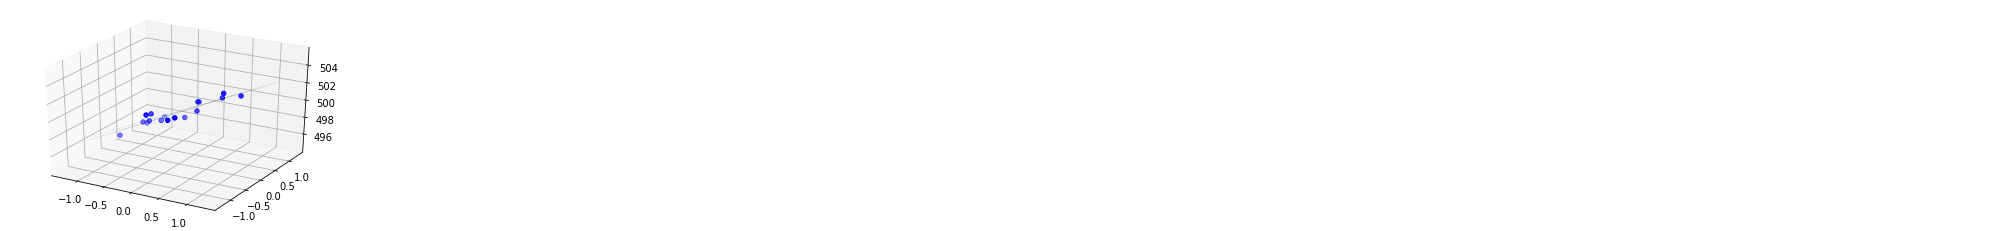

In [5]:
# Define prediction parameters
kdict = [{'type': 'linear', 'scaling': 0.9},
         {'type': 'constant', 'const': 0.0}]


# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp1 = GaussianProcess(kernel_list=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True,
                      scale_optimizer=False)
# Do predictions.
linear = gp1.predict(test_fp=std['test'], get_validation_error=True,
                     test_target=afunc(test))
prediction = np.array(linear['prediction']) * train_targets['std'] + \
    train_targets['mean']
error = get_error(prediction, afunc(test))
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   prediction.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')
print('Gaussian linear regression prediction:', error['absolute_average'])

Notice that Ridge regression and the Gaussian linear model are almost identical.

## Model example 3 - Gaussian Process with squared exponential kernel.

This kernel is also known as the Gaussian kernel, which is a bit confusing and not related to the term Gaussian process.

Squared exponential kernel Gaussian process prediction: 0.22360851396663284


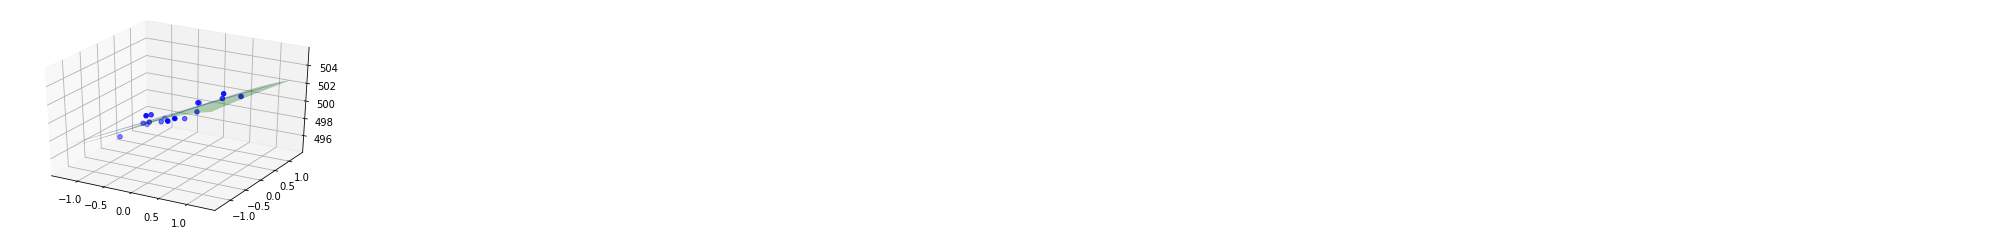

In [6]:
# Set up the prediction routine and optimize hyperparameters.
kdict = [{'type': 'gaussian', 'width': [0.3, 3.], 'scaling': 0.9}]
# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp2 = GaussianProcess(kernel_list=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True,
                      scale_optimizer=False)
# Do the optimized predictions.
gaussian = gp2.predict(test_fp=std['test'])
# Put predictions back on real scale.
prediction = np.array(gaussian['prediction']) * train_targets['std'] + \
    train_targets['mean']
# Get average errors.
error = get_error(prediction, afunc(test))
# Plotting.
plt3d = plt.figure().gca(projection='3d')
# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')
# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   prediction.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')
print('Squared exponential kernel Gaussian process prediction:', error['absolute_average'])

If the noise is high enough and/or the training data is sparse enough, you will get some smooth wiggles from the squared exponential kernel, even though the underlying function is linear. This is because the squared exponential kernel is local and does not extrapolate well, whereas the linear models are global and extrapolates well.

### Experiment and get intuition.

Try playing around with the training set size (density) by changing the `train_points` variable, and the magnitude of the noise by playing with the `noise_magnitude` variable and rerun the models.